In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import itertools
import os
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from IPython.display import Markdown, display

torch.set_grad_enabled(False)

from shared_definitions import *
from shared_visualization_utils import *

sys.path.insert(0, os.path.abspath(".."))

sns.set_theme(style="white", context="notebook", rc={"figure.figsize": (14, 10)})


In [3]:
result_df, indirect_effects_by_model_and_dataset, top_heads_by_model_and_dataset = load_and_combine_raw_results()
result_df.head()

2025-05-14 21:23:35.285 | INFO     | shared_definitions:load_and_combine_raw_results:416 - Loading cached results from data/full_results.pkl.gz


,model,dataset,top_n_prompt_acc,top_1_prompt_acc,top_n_prompts,0_shot_acc,1_shot_acc,2_shot_acc,3_shot_acc,4_shot_acc,...,zs_universal_10_heads_max_acc_layer,zs_universal_20_heads_by_layer_acc,zs_universal_20_heads_max_acc,zs_universal_20_heads_max_acc_layer,fs_shuffled_universal_40_heads_by_layer_acc,fs_shuffled_universal_40_heads_max_acc,fs_shuffled_universal_40_heads_max_acc_layer,zs_universal_40_heads_by_layer_acc,zs_universal_40_heads_max_acc,zs_universal_40_heads_max_acc_layer
0,Llama-3.2-1B-Instruct,choose_first_of_3,0.767429,0.888571,"[Extract the first token, Output the word at t...",0.636667,0.863333,0.896667,0.896667,0.913333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Llama-3.2-1B-Instruct,capitalize_first_letter,0.936907,0.963093,"[What is the initial letter of this word?, Det...",0.000000,0.688525,0.852459,0.918033,0.950820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Llama-3.2-1B-Instruct,capitalize_second_letter,0.110364,0.160000,"[What's the special letter in this word?, Dete...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Llama-3.2-1B-Instruct,english-french,0.663200,0.678224,"[English word in French, English word to Frenc...",0.011348,0.352482,0.587234,0.662411,0.687943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Llama-3.2-1B-Instruct,choose_first_of_5,0.737286,0.772857,"[Find the starting word of the input sequence,...",0.616667,0.810000,0.870000,0.890000,0.940000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# SKIP_OLMO = True
# if SKIP_OLMO:
#     result_df = result_df[~result_df.model.str.contains("OLMo")]
#     indirect_effects_by_model_and_dataset = {
#         k: v for k, v in indirect_effects_by_model_and_dataset.items() if "OLMo" not in k
#     }
#     top_heads_by_model_and_dataset = {
#         k: v for k, v in top_heads_by_model_and_dataset.items() if "OLMo" not in k
#     }

# only ran this on the 3.2 models so far:
result_df = result_df[result_df.model.str.contains(r"3\.\d")]
indirect_effects_by_model_and_dataset = {k: v for k, v in indirect_effects_by_model_and_dataset.items() if "3." in k}
top_heads_by_model_and_dataset = {k: v for k, v in top_heads_by_model_and_dataset.items() if "3." in k}

RELEVANT_MODELS = [model for model in ORDERED_MODELS if "3." in model]

# RQ2.2: If one function vector is good, are more better?

Testing the joint intervention with both FVs


In [5]:
PLOT_SEM = True  # True for SEM, False for STD, None for neither
USE_ONE_THIRD_LAYER = False
LAYER_PLOT_SUFFIX = "one_third_layer" if USE_ONE_THIRD_LAYER else "max_acc_layer"

result_with_same_layer_acc_df = add_same_layer_results(
    result_df,
    special_type=None,
    include_icl=True,
    use_both_zs_and_fs_for_top_layer=True,
    use_one_third_layer_rule=USE_ONE_THIRD_LAYER,
)

result_with_same_layer_acc_df = add_same_layer_results(
    result_with_same_layer_acc_df,
    special_type="joint_intervention",
    include_icl=False,
    use_both_zs_and_fs_for_top_layer=True,
    use_one_third_layer_rule=USE_ONE_THIRD_LAYER,
)

2025-05-14 21:23:36.740 | WARNING  | shared_definitions:find_max_acc_layer:573 - No data for Llama-3.2-1B-Instruct | short | ['fs_shuffled_universal_both_all_40_heads_by_layer_acc', 'zs_universal_both_all_40_heads_by_layer_acc']
2025-05-14 21:23:36.750 | WARNING  | shared_definitions:find_max_acc_layer:573 - No data for Llama-3.2-1B-Instruct | long | ['fs_shuffled_universal_both_all_40_heads_by_layer_acc', 'zs_universal_both_all_40_heads_by_layer_acc']
2025-05-14 21:23:36.762 | WARNING  | shared_definitions:find_max_acc_layer:573 - No data for Llama-3.2-1B-Instruct | both | ['fs_shuffled_universal_both_all_40_heads_by_layer_acc', 'zs_universal_both_all_40_heads_by_layer_acc']
2025-05-14 21:23:36.772 | WARNING  | shared_definitions:find_max_acc_layer:573 - No data for Llama-3.2-1B-Instruct | icl | ['fs_shuffled_universal_40_heads_by_layer_acc', 'zs_universal_40_heads_by_layer_acc']
2025-05-14 21:23:36.784 | WARNING  | shared_definitions:find_max_acc_layer:573 - No data for Llama-3.2-3B 

In [6]:
MISSING_DATASETS_BY_MODEL = {}
n_top_heads = 10

for model in RELEVANT_MODELS:
    model_missing_datasets = set()
    for prompt_type in (SHORT, LONG, ICL):
        model_df = result_with_same_layer_acc_df[
            (result_with_same_layer_acc_df.model == model) & (result_with_same_layer_acc_df.prompt_type == prompt_type)
        ]

        zs_prefix = get_zs_prefix(True)
        universal_layer_acc_key = f"{zs_prefix}_{n_top_heads}_heads_universal_FV_acc"
        missing_datasets = model_df[model_df[universal_layer_acc_key].isna()].dataset.unique()
        model_missing_datasets.update(missing_datasets)

    MISSING_DATASETS_BY_MODEL[model] = model_missing_datasets


row_filter = result_with_same_layer_acc_df.apply(
    lambda row: row.dataset not in MISSING_DATASETS_BY_MODEL[row.model], axis=1
)

matched_datasets_result_with_same_layer_acc_df = result_with_same_layer_acc_df[row_filter].copy(deep=True)

In [7]:
from shared_visualization_utils import print_summary

summary_columns = [
    "10_shot_acc",
    "top_1_prompt_acc",
    "top_n_prompt_acc",
    "0_shot_acc",
    "zs_universal_both_all_10_heads_same_layer_acc",
    "zs_universal_icl_all_10_heads_same_layer_acc",
    "zs_universal_both_joint_intervention_all_10_heads_same_layer_acc",
    "zs_universal_both_all_20_heads_same_layer_acc",
    "zs_universal_icl_all_20_heads_same_layer_acc",
    "zs_universal_both_joint_intervention_all_20_heads_same_layer_acc",
]

summary_columns_shuffled_10_shot = [
    "10_shot_acc",
    "top_1_prompt_acc",
    "top_n_prompt_acc",
    "shuffled_10_shot_acc",
    "fs_shuffled_universal_both_all_10_heads_same_layer_acc",
    "fs_shuffled_universal_icl_all_10_heads_same_layer_acc",
    "fs_shuffled_universal_both_joint_intervention_all_10_heads_same_layer_acc",
    "fs_shuffled_universal_both_all_20_heads_same_layer_acc",
    "fs_shuffled_universal_icl_all_20_heads_same_layer_acc",
    "fs_shuffled_universal_both_joint_intervention_all_20_heads_same_layer_acc",
]

summary_layer_columns = [
    "zs_both_10_max_acc_layer",
    "zs_both_10_max_acc_layer_depth",
    "zs_icl_10_max_acc_layer",
    "zs_icl_10_max_acc_layer_depth",
    "zs_both_joint_intervention_10_max_acc_layer",
    "zs_both_joint_intervention_10_max_acc_layer_depth",
    # 'fs_shuffled_both_10_max_acc_layer',
    # 'fs_shuffled_both_10_max_acc_layer_depth',
    # 'fs_shuffled_icl_10_max_acc_layer',
    # 'fs_shuffled_icl_10_max_acc_layer_depth',
    # 'fs_shuffled_both_joint_intervention_10_max_acc_layer',
    # 'fs_shuffled_both_joint_intervention_10_max_acc_layer_depth',
    "zs_both_20_max_acc_layer",
    "zs_both_20_max_acc_layer_depth",
    "zs_icl_20_max_acc_layer",
    "zs_icl_20_max_acc_layer_depth",
    "zs_both_joint_intervention_20_max_acc_layer",
    "zs_both_joint_intervention_20_max_acc_layer_depth",
    # 'fs_shuffled_both_20_max_acc_layer',
    # 'fs_shuffled_both_20_max_acc_layer_depth',
    # 'fs_shuffled_icl_20_max_acc_layer',
    # 'fs_shuffled_icl_20_max_acc_layer_depth',
    # 'fs_shuffled_both_joint_intervention_20_max_acc_layer',
    # 'fs_shuffled_both_joint_intervention_20_max_acc_layer_depth',
]

display(Markdown("## Summary (aggregated by model) - 0-shot"))
zero_shot_metric_dicts = print_summary(
    matched_datasets_result_with_same_layer_acc_df, summary_columns, [3, 7], use_sem=PLOT_SEM
)
display(Markdown("## Summary (aggregated by model) - Shuffled 10-shot"))
shuffled_ten_shot_metric_dicts = print_summary(
    matched_datasets_result_with_same_layer_acc_df, summary_columns_shuffled_10_shot, [3, 7], use_sem=PLOT_SEM
)
display(Markdown("## Summary (aggregated by model) - max acc layer/depths"))
layer_depth_metric_dicts = print_summary(
    matched_datasets_result_with_same_layer_acc_df,
    summary_layer_columns,
    [
        6,
    ],
    agg="first",
)


zero_shot_model_dicts = defaultdict(dict)
for metric_dict in zero_shot_metric_dicts:
    metric_dict = {**metric_dict}
    metric = metric_dict.pop("metric")
    for model, value in metric_dict.items():
        zero_shot_model_dicts[model][metric] = value


shuffled_ten_shot_model_dicts = defaultdict(dict)
for metric_dict in shuffled_ten_shot_metric_dicts:
    metric_dict = {**metric_dict}
    metric = metric_dict.pop("metric")
    for model, value in metric_dict.items():
        shuffled_ten_shot_model_dicts[model][metric] = value


layer_depth_model_dicts = defaultdict(dict)
for metric_dict in layer_depth_metric_dicts:
    metric_dict = {**metric_dict}
    metric = metric_dict.pop("metric")
    for model, value in metric_dict.items():
        layer_depth_model_dicts[model][metric] = value

## Summary (aggregated by model) - 0-shot

| metric                      | Llama-3.2-1B    | Llama-3.2-1B-Instruct   | Llama-3.2-3B    | Llama-3.2-3B-Instruct   | Llama-3.1-8B    | Llama-3.1-8B-Instruct   | mean (no 13b)   |
|-----------------------------|-----------------|-------------------------|-----------------|-------------------------|-----------------|-------------------------|-----------------|
| 10-shot                     | 0.6562 ± 0.0211 | 0.6930 ± 0.0191         | 0.7531 ± 0.0205 | 0.7895 ± 0.0173         | 0.8207 ± 0.0179 | 0.8456 ± 0.0171         | 0.7597 ± 0.0188 |
| Top-1 prompt                | 0.6281 ± 0.0246 | 0.7164 ± 0.0226         | 0.7654 ± 0.0225 | 0.8638 ± 0.0172         | 0.8200 ± 0.0208 | 0.8874 ± 0.0159         | 0.7802 ± 0.0206 |
| Top-5 prompts (mean)        | 0.5484 ± 0.0241 | 0.6598 ± 0.0225         | 0.7105 ± 0.0227 | 0.8330 ± 0.0184         | 0.7668 ± 0.0225 | 0.8507 ± 0.0185         | 0.7282 ± 0.0214 |
|  |
| 0-shot                      | 0.1779 ± 0.0169 | 0.1566 ± 0.0136         | 0.1530 ± 0.0163 | 0.1066 ± 0.0088         | 0.1283 ± 0.0122 | 0.0772 ± 0.0071         | 0.1333 ± 0.0125 |
| Prompt FV 0-shot (10 heads) | 0.3344 ± 0.0285 | 0.4237 ± 0.0279         | 0.3302 ± 0.0287 | 0.5493 ± 0.0278         | 0.4050 ± 0.0297 | 0.5881 ± 0.0289         | 0.4385 ± 0.0286 |
| ICL FV 0-shot (10 heads)    | 0.4454 ± 0.0388 | 0.5096 ± 0.0372         | 0.4757 ± 0.0326 | 0.5529 ± 0.0368         | 0.5023 ± 0.0373 | 0.5512 ± 0.0373         | 0.5062 ± 0.0367 |
| Joint FV 0-shot (10 heads)  | 0.6631 ± 0.0294 | 0.6953 ± 0.0269         | 0.6282 ± 0.0296 | 0.7565 ± 0.0234         | 0.7072 ± 0.0283 | 0.7772 ± 0.0218         | 0.7046 ± 0.0266 |
|  |
| Prompt FV 0-shot (20 heads) | 0.4008 ± 0.0315 | 0.4616 ± 0.0286         | 0.4550 ± 0.0329 | 0.6415 ± 0.0278         | 0.3791 ± 0.0274 | 0.6541 ± 0.0277         | 0.4987 ± 0.0293 |
| ICL FV 0-shot (20 heads)    | 0.4925 ± 0.0395 | 0.5494 ± 0.0366         | 0.5736 ± 0.0345 | 0.5595 ± 0.0362         | 0.4930 ± 0.0404 | 0.6019 ± 0.0399         | 0.5450 ± 0.0378 |
| Joint FV 0-shot (20 heads)  | 0.7446 ± 0.0274 | 0.7721 ± 0.0222         | 0.7112 ± 0.0268 | 0.8089 ± 0.0218         | 0.5269 ± 0.0297 | 0.8202 ± 0.0224         | 0.7307 ± 0.0251 |

## Summary (aggregated by model) - Shuffled 10-shot

| metric                                | Llama-3.2-1B    | Llama-3.2-1B-Instruct   | Llama-3.2-3B    | Llama-3.2-3B-Instruct   | Llama-3.1-8B    | Llama-3.1-8B-Instruct   | mean (no 13b)   |
|---------------------------------------|-----------------|-------------------------|-----------------|-------------------------|-----------------|-------------------------|-----------------|
| 10-shot                               | 0.6562 ± 0.0211 | 0.6930 ± 0.0191         | 0.7531 ± 0.0205 | 0.7895 ± 0.0173         | 0.8207 ± 0.0179 | 0.8456 ± 0.0171         | 0.7597 ± 0.0188 |
| Top-1 prompt                          | 0.6281 ± 0.0246 | 0.7164 ± 0.0226         | 0.7654 ± 0.0225 | 0.8638 ± 0.0172         | 0.8200 ± 0.0208 | 0.8874 ± 0.0159         | 0.7802 ± 0.0206 |
| Top-5 prompts (mean)                  | 0.5484 ± 0.0241 | 0.6598 ± 0.0225         | 0.7105 ± 0.0227 | 0.8330 ± 0.0184         | 0.7668 ± 0.0225 | 0.8507 ± 0.0185         | 0.7282 ± 0.0214 |
|  |
| Shuffled 10-shot                      | 0.1300 ± 0.0141 | 0.1674 ± 0.0174         | 0.1536 ± 0.0159 | 0.1858 ± 0.0154         | 0.1991 ± 0.0148 | 0.1793 ± 0.0160         | 0.1692 ± 0.0156 |
| Prompt FV shuffled 10-shot (10 heads) | 0.2442 ± 0.0282 | 0.2941 ± 0.0300         | 0.1122 ± 0.0213 | 0.3408 ± 0.0237         | 0.2775 ± 0.0197 | 0.2562 ± 0.0242         | 0.2542 ± 0.0245 |
| ICL FV shuffled 10-shot (10 heads)    | 0.7375 ± 0.0267 | 0.6382 ± 0.0311         | 0.7045 ± 0.0285 | 0.7876 ± 0.0294         | 0.7115 ± 0.0328 | 0.6894 ± 0.0345         | 0.7114 ± 0.0305 |
| Joint FV shuffled 10-shot (10 heads)  | 0.7920 ± 0.0212 | 0.7739 ± 0.0193         | 0.7632 ± 0.0204 | 0.8351 ± 0.0166         | 0.7564 ± 0.0220 | 0.7418 ± 0.0237         | 0.7771 ± 0.0205 |
|  |
| Prompt FV shuffled 10-shot (20 heads) | 0.2915 ± 0.0300 | 0.3044 ± 0.0326         | 0.1839 ± 0.0248 | 0.4603 ± 0.0232         | 0.2401 ± 0.0244 | 0.3333 ± 0.0248         | 0.3022 ± 0.0267 |
| ICL FV shuffled 10-shot (20 heads)    | 0.7721 ± 0.0262 | 0.6469 ± 0.0310         | 0.7128 ± 0.0281 | 0.8325 ± 0.0234         | 0.6039 ± 0.0369 | 0.7462 ± 0.0324         | 0.7191 ± 0.0296 |
| Joint FV shuffled 10-shot (20 heads)  | 0.8475 ± 0.0176 | 0.7996 ± 0.0186         | 0.7860 ± 0.0192 | 0.8908 ± 0.0138         | 0.5661 ± 0.0283 | 0.8484 ± 0.0192         | 0.7897 ± 0.0194 |

## Summary (aggregated by model) - max acc layer/depths

| metric                                            | Llama-3.2-1B   | Llama-3.2-1B-Instruct   | Llama-3.2-3B                               | Llama-3.2-3B-Instruct                      | Llama-3.1-8B     | Llama-3.1-8B-Instruct   |
|---------------------------------------------------|----------------|-------------------------|--------------------------------------------|--------------------------------------------|------------------|-------------------------|
| zs_both_10_max_acc_layer                          | 7              | 7                       | 12                                         | 11                                         | 16               | 14                      |
| zs_both_10_max_acc_layer_depth                    | 0.4375         | 0.4375                  | 0.42857142857142855                        | 0.39285714285714285                        | 0.5              | 0.4375                  |
| zs_icl_10_max_acc_layer                           | 7              | 8                       | 13                                         | 13                                         | 14               | 14                      |
| zs_icl_10_max_acc_layer_depth                     | 0.4375         | 0.5                     | 0.4642857142857143                         | 0.4642857142857143                         | 0.4375           | 0.4375                  |
| zs_both_joint_intervention_10_max_acc_layer       | (6, 6)         | (6, 6)                  | (9, 9)                                     | (12, 12)                                   | (14, 14)         | (13, 13)                |
| zs_both_joint_intervention_10_max_acc_layer_depth | (0.375, 0.375) | (0.375, 0.375)          | (0.32142857142857145, 0.32142857142857145) | (0.42857142857142855, 0.42857142857142855) | (0.4375, 0.4375) | (0.40625, 0.40625)      |
|  |
| zs_both_20_max_acc_layer                          | 6              | 6                       | 9                                          | 11                                         | 15               | 14                      |
| zs_both_20_max_acc_layer_depth                    | 0.375          | 0.375                   | 0.32142857142857145                        | 0.39285714285714285                        | 0.46875          | 0.4375                  |
| zs_icl_20_max_acc_layer                           | 7              | 8                       | 13                                         | 11                                         | 9                | 14                      |
| zs_icl_20_max_acc_layer_depth                     | 0.4375         | 0.5                     | 0.4642857142857143                         | 0.39285714285714285                        | 0.28125          | 0.4375                  |
| zs_both_joint_intervention_20_max_acc_layer       | (6, 6)         | (6, 6)                  | (9, 9)                                     | (11, 11)                                   | (8, 10)          | (13, 13)                |
| zs_both_joint_intervention_20_max_acc_layer_depth | (0.375, 0.375) | (0.375, 0.375)          | (0.32142857142857145, 0.32142857142857145) | (0.39285714285714285, 0.39285714285714285) | (0.25, 0.3125)   | (0.40625, 0.40625)      |

In [8]:
result_with_same_layer_localizers_df = result_with_same_layer_acc_df

result_with_same_layer_localizers_df = add_same_layer_results(
    result_with_same_layer_localizers_df,
    special_type="icl_top_heads",
    include_icl=False,
    use_both_zs_and_fs_for_top_layer=True,
    use_one_third_layer_rule=USE_ONE_THIRD_LAYER,
)


result_with_same_layer_localizers_df = add_same_layer_results(
    result_with_same_layer_localizers_df,
    special_type="icl_mean_activations",
    include_icl=False,
    use_both_zs_and_fs_for_top_layer=True,
    use_one_third_layer_rule=USE_ONE_THIRD_LAYER,
)

row_filter = result_with_same_layer_localizers_df.apply(
    lambda row: row.dataset not in MISSING_DATASETS_BY_MODEL[row.model], axis=1
)

matched_datasets_result_with_same_layer_localizers_df = result_with_same_layer_localizers_df[row_filter].copy(deep=True)

2025-05-14 21:23:41.816 | WARNING  | shared_definitions:find_max_acc_layer:573 - No data for Llama-3.2-1B-Instruct | short | ['fs_shuffled_universal_icl_top_heads_40_heads_by_layer_acc', 'zs_universal_icl_top_heads_40_heads_by_layer_acc']
2025-05-14 21:23:41.826 | WARNING  | shared_definitions:find_max_acc_layer:573 - No data for Llama-3.2-1B-Instruct | long | ['fs_shuffled_universal_icl_top_heads_40_heads_by_layer_acc', 'zs_universal_icl_top_heads_40_heads_by_layer_acc']
2025-05-14 21:23:41.839 | WARNING  | shared_definitions:find_max_acc_layer:573 - No data for Llama-3.2-1B-Instruct | both | ['fs_shuffled_universal_icl_top_heads_40_heads_by_layer_acc', 'zs_universal_icl_top_heads_40_heads_by_layer_acc']
2025-05-14 21:23:41.851 | WARNING  | shared_definitions:find_max_acc_layer:573 - No data for Llama-3.2-3B | short | ['fs_shuffled_universal_icl_top_heads_40_heads_by_layer_acc', 'zs_universal_icl_top_heads_40_heads_by_layer_acc']
2025-05-14 21:23:41.863 | WARNING  | shared_definitions

In [9]:
summary_columns = [
    "10_shot_acc",
    "top_1_prompt_acc",
    "top_n_prompt_acc",
    "0_shot_acc",
    "zs_universal_both_all_10_heads_same_layer_acc",
    "zs_universal_icl_all_10_heads_same_layer_acc",
    "zs_universal_both_joint_intervention_all_10_heads_same_layer_acc",
    "zs_universal_both_icl_mean_activations_all_10_heads_same_layer_acc",
    "zs_universal_both_icl_top_heads_all_10_heads_same_layer_acc",
    # 'zs_universal_both_all_minus_icl_mean_activations_10_heads_same_layer_acc',
    # 'zs_universal_both_all_minus_icl_top_heads_10_heads_same_layer_acc',
    "zs_universal_both_all_20_heads_same_layer_acc",
    "zs_universal_icl_all_20_heads_same_layer_acc",
    "zs_universal_both_joint_intervention_all_20_heads_same_layer_acc",
    "zs_universal_both_icl_mean_activations_all_20_heads_same_layer_acc",
    "zs_universal_both_icl_top_heads_all_20_heads_same_layer_acc",
    # 'zs_universal_both_all_minus_icl_mean_activations_20_heads_same_layer_acc',
    # 'zs_universal_both_all_minus_icl_top_heads_20_heads_same_layer_acc',
]

summary_columns_shuffled_10_shot = [
    "10_shot_acc",
    "top_1_prompt_acc",
    "top_n_prompt_acc",
    "shuffled_10_shot_acc",
    "fs_shuffled_universal_both_all_10_heads_same_layer_acc",
    "fs_shuffled_universal_icl_all_10_heads_same_layer_acc",
    "fs_shuffled_universal_both_joint_intervention_all_10_heads_same_layer_acc",
    "fs_shuffled_universal_both_icl_mean_activations_all_10_heads_same_layer_acc",
    "fs_shuffled_universal_both_icl_top_heads_all_10_heads_same_layer_acc",
    # 'fs_shuffled_universal_icl_all_minus_icl_mean_activations_10_heads_same_layer_acc',
    # 'fs_shuffled_universal_icl_all_minus_icl_mean_activations_20_heads_same_layer_acc',
    "fs_shuffled_universal_both_all_20_heads_same_layer_acc",
    "fs_shuffled_universal_icl_all_20_heads_same_layer_acc",
    "fs_shuffled_universal_both_joint_intervention_all_20_heads_same_layer_acc",
    "fs_shuffled_universal_both_icl_mean_activations_all_20_heads_same_layer_acc",
    "fs_shuffled_universal_both_icl_top_heads_all_20_heads_same_layer_acc",
    # 'fs_shuffled_universal_icl_all_minus_icl_top_heads_10_heads_same_layer_acc',
    # 'fs_shuffled_universal_icl_all_minus_icl_top_heads_20_heads_same_layer_acc'
]

display(Markdown("## Summary (aggregated by model) - 0-shot"))
localizers_zero_shot_metric_dicts = print_summary(
    matched_datasets_result_with_same_layer_localizers_df, summary_columns, [3, 11], use_sem=PLOT_SEM
)
display(Markdown("## Summary (aggregated by model) - Shuffled 10-shot"))
localizers_shuffled_ten_shot_metric_dicts = print_summary(
    matched_datasets_result_with_same_layer_localizers_df, summary_columns_shuffled_10_shot, [3, 11], use_sem=PLOT_SEM
)


localizers_zero_shot_model_dicts = defaultdict(dict)
for metric_dict in localizers_zero_shot_metric_dicts:
    metric_dict = {**metric_dict}
    metric = metric_dict.pop("metric")
    for model, value in metric_dict.items():
        localizers_zero_shot_model_dicts[model][metric] = value


localizers_shuffled_ten_shot_model_dicts = defaultdict(dict)
for metric_dict in localizers_shuffled_ten_shot_metric_dicts:
    metric_dict = {**metric_dict}
    metric = metric_dict.pop("metric")
    for model, value in metric_dict.items():
        localizers_shuffled_ten_shot_model_dicts[model][metric] = value


combined_model_dicts = {
    model: {**zs_model_dict, **localizers_shuffled_ten_shot_model_dicts[model]}
    for model, zs_model_dict in localizers_zero_shot_model_dicts.items()
}

## Summary (aggregated by model) - 0-shot

| metric                               | Llama-3.2-1B    | Llama-3.2-1B-Instruct   | Llama-3.2-3B    | Llama-3.2-3B-Instruct   | Llama-3.1-8B    | Llama-3.1-8B-Instruct   | mean (no 13b)   |
|--------------------------------------|-----------------|-------------------------|-----------------|-------------------------|-----------------|-------------------------|-----------------|
| 10-shot                              | 0.6562 ± 0.0211 | 0.6930 ± 0.0191         | 0.7531 ± 0.0205 | 0.7895 ± 0.0173         | 0.8207 ± 0.0179 | 0.8456 ± 0.0171         | 0.7597 ± 0.0188 |
| Top-1 prompt                         | 0.6281 ± 0.0246 | 0.7164 ± 0.0226         | 0.7654 ± 0.0225 | 0.8638 ± 0.0172         | 0.8200 ± 0.0208 | 0.8874 ± 0.0159         | 0.7802 ± 0.0206 |
| Top-5 prompts (mean)                 | 0.5484 ± 0.0241 | 0.6598 ± 0.0225         | 0.7105 ± 0.0227 | 0.8330 ± 0.0184         | 0.7668 ± 0.0225 | 0.8507 ± 0.0185         | 0.7282 ± 0.0214 |
|  |
| 0-shot                               | 0.1779 ± 0.0169 | 0.1566 ± 0.0136         | 0.1530 ± 0.0163 | 0.1066 ± 0.0088         | 0.1283 ± 0.0122 | 0.0772 ± 0.0071         | 0.1333 ± 0.0125 |
| Prompt FV 0-shot (10 heads)          | 0.3344 ± 0.0285 | 0.4237 ± 0.0279         | 0.3302 ± 0.0287 | 0.5493 ± 0.0278         | 0.4050 ± 0.0297 | 0.5881 ± 0.0289         | 0.4385 ± 0.0286 |
| ICL FV 0-shot (10 heads)             | 0.4454 ± 0.0388 | 0.5096 ± 0.0372         | 0.4757 ± 0.0326 | 0.5529 ± 0.0368         | 0.5023 ± 0.0373 | 0.5512 ± 0.0373         | 0.5062 ± 0.0367 |
| Joint FV 0-shot (10 heads)           | 0.6631 ± 0.0294 | 0.6953 ± 0.0269         | 0.6282 ± 0.0296 | 0.7565 ± 0.0234         | 0.7072 ± 0.0283 | 0.7772 ± 0.0218         | 0.7046 ± 0.0266 |
| ICL activations FV 0-shot (10 heads) | 0.2916 ± 0.0305 | 0.3787 ± 0.0283         | 0.1852 ± 0.0228 | 0.5095 ± 0.0276         | 0.3169 ± 0.0250 | 0.4335 ± 0.0295         | 0.3526 ± 0.0273 |
| ICL top heads FV 0-shot (10 heads)   | 0.3170 ± 0.0303 | 0.3227 ± 0.0258         | 0.2535 ± 0.0248 | 0.2457 ± 0.0197         | 0.2239 ± 0.0228 | 0.1868 ± 0.0156         | 0.2583 ± 0.0232 |
| Prompt FV 0-shot (20 heads)          | 0.4008 ± 0.0315 | 0.4616 ± 0.0286         | 0.4550 ± 0.0329 | 0.6415 ± 0.0278         | 0.3791 ± 0.0274 | 0.6541 ± 0.0277         | 0.4987 ± 0.0293 |
| ICL FV 0-shot (20 heads)             | 0.4925 ± 0.0395 | 0.5494 ± 0.0366         | 0.5736 ± 0.0345 | 0.5595 ± 0.0362         | 0.4930 ± 0.0404 | 0.6019 ± 0.0399         | 0.5450 ± 0.0378 |
|  |
| Joint FV 0-shot (20 heads)           | 0.7446 ± 0.0274 | 0.7721 ± 0.0222         | 0.7112 ± 0.0268 | 0.8089 ± 0.0218         | 0.5269 ± 0.0297 | 0.8202 ± 0.0224         | 0.7307 ± 0.0251 |
| ICL activations FV 0-shot (20 heads) | 0.3398 ± 0.0316 | 0.3880 ± 0.0275         | 0.3416 ± 0.0330 | 0.5395 ± 0.0282         | 0.2903 ± 0.0246 | 0.5779 ± 0.0301         | 0.4129 ± 0.0292 |
| ICL top heads FV 0-shot (20 heads)   | 0.3286 ± 0.0319 | 0.3057 ± 0.0251         | 0.2736 ± 0.0256 | 0.2544 ± 0.0210         | 0.2520 ± 0.0242 | 0.3534 ± 0.0224         | 0.2946 ± 0.0250 |

## Summary (aggregated by model) - Shuffled 10-shot

| metric                                         | Llama-3.2-1B    | Llama-3.2-1B-Instruct   | Llama-3.2-3B    | Llama-3.2-3B-Instruct   | Llama-3.1-8B    | Llama-3.1-8B-Instruct   | mean (no 13b)   |
|------------------------------------------------|-----------------|-------------------------|-----------------|-------------------------|-----------------|-------------------------|-----------------|
| 10-shot                                        | 0.6562 ± 0.0211 | 0.6930 ± 0.0191         | 0.7531 ± 0.0205 | 0.7895 ± 0.0173         | 0.8207 ± 0.0179 | 0.8456 ± 0.0171         | 0.7597 ± 0.0188 |
| Top-1 prompt                                   | 0.6281 ± 0.0246 | 0.7164 ± 0.0226         | 0.7654 ± 0.0225 | 0.8638 ± 0.0172         | 0.8200 ± 0.0208 | 0.8874 ± 0.0159         | 0.7802 ± 0.0206 |
| Top-5 prompts (mean)                           | 0.5484 ± 0.0241 | 0.6598 ± 0.0225         | 0.7105 ± 0.0227 | 0.8330 ± 0.0184         | 0.7668 ± 0.0225 | 0.8507 ± 0.0185         | 0.7282 ± 0.0214 |
|  |
| Shuffled 10-shot                               | 0.1300 ± 0.0141 | 0.1674 ± 0.0174         | 0.1536 ± 0.0159 | 0.1858 ± 0.0154         | 0.1991 ± 0.0148 | 0.1793 ± 0.0160         | 0.1692 ± 0.0156 |
| Prompt FV shuffled 10-shot (10 heads)          | 0.2442 ± 0.0282 | 0.2941 ± 0.0300         | 0.1122 ± 0.0213 | 0.3408 ± 0.0237         | 0.2775 ± 0.0197 | 0.2562 ± 0.0242         | 0.2542 ± 0.0245 |
| ICL FV shuffled 10-shot (10 heads)             | 0.7375 ± 0.0267 | 0.6382 ± 0.0311         | 0.7045 ± 0.0285 | 0.7876 ± 0.0294         | 0.7115 ± 0.0328 | 0.6894 ± 0.0345         | 0.7114 ± 0.0305 |
| Joint FV shuffled 10-shot (10 heads)           | 0.7920 ± 0.0212 | 0.7739 ± 0.0193         | 0.7632 ± 0.0204 | 0.8351 ± 0.0166         | 0.7564 ± 0.0220 | 0.7418 ± 0.0237         | 0.7771 ± 0.0205 |
| ICL activations FV shuffled 10-shot (10 heads) | 0.2474 ± 0.0284 | 0.3281 ± 0.0252         | 0.1792 ± 0.0192 | 0.5128 ± 0.0205         | 0.3815 ± 0.0194 | 0.2959 ± 0.0206         | 0.3242 ± 0.0222 |
| ICL top heads FV shuffled 10-shot (10 heads)   | 0.2597 ± 0.0267 | 0.2610 ± 0.0284         | 0.2531 ± 0.0215 | 0.2701 ± 0.0193         | 0.2961 ± 0.0198 | 0.2437 ± 0.0193         | 0.2639 ± 0.0225 |
| Prompt FV shuffled 10-shot (20 heads)          | 0.2915 ± 0.0300 | 0.3044 ± 0.0326         | 0.1839 ± 0.0248 | 0.4603 ± 0.0232         | 0.2401 ± 0.0244 | 0.3333 ± 0.0248         | 0.3022 ± 0.0267 |
| ICL FV shuffled 10-shot (20 heads)             | 0.7721 ± 0.0262 | 0.6469 ± 0.0310         | 0.7128 ± 0.0281 | 0.8325 ± 0.0234         | 0.6039 ± 0.0369 | 0.7462 ± 0.0324         | 0.7191 ± 0.0296 |
|  |
| Joint FV shuffled 10-shot (20 heads)           | 0.8475 ± 0.0176 | 0.7996 ± 0.0186         | 0.7860 ± 0.0192 | 0.8908 ± 0.0138         | 0.5661 ± 0.0283 | 0.8484 ± 0.0192         | 0.7897 ± 0.0194 |
| ICL activations FV shuffled 10-shot (20 heads) | 0.3008 ± 0.0286 | 0.3699 ± 0.0225         | 0.0913 ± 0.0203 | 0.6036 ± 0.0220         | 0.1703 ± 0.0229 | 0.5120 ± 0.0215         | 0.3413 ± 0.0230 |
| ICL top heads FV shuffled 10-shot (20 heads)   | 0.2769 ± 0.0259 | 0.2631 ± 0.0285         | 0.2674 ± 0.0225 | 0.3321 ± 0.0193         | 0.2524 ± 0.0236 | 0.2794 ± 0.0199         | 0.2785 ± 0.0233 |

Manually compute some diff results that can't just be averaged from the raw data


In [10]:
from shared_visualization_utils import METRIC_RENAMES

err_type = "sem" if PLOT_SEM else "std"

for prefix in ("zs", "fs_shuffled"):
    orig_fv_type = "both_all" if prefix == "zs" else "icl_all"

    for other_fv_type in ("icl_mean_activations", "icl_top_heads"):
        for n_heads in (10, 20):
            orig_column = f"{prefix}_universal_{orig_fv_type}_{n_heads}_heads_same_layer_acc"
            other_column = f"{prefix}_universal_both_{other_fv_type}_all_{n_heads}_heads_same_layer_acc"
            diff_column = f"{prefix}_universal_{orig_fv_type}_minus_{other_fv_type}_{n_heads}_heads_same_layer_acc"

            diff_metric = METRIC_RENAMES.get(diff_column, diff_column)

            gb = matched_datasets_result_with_same_layer_localizers_df.groupby(
                [
                    "model",
                    "dataset",
                ]
            )
            diff = gb[orig_column].mean() - gb[other_column].mean()
            r = diff.groupby("model").agg(["mean", err_type])

            for model, row in r.iterrows():
                combined_model_dicts[model][diff_metric] = (row["mean"], row[err_type])

            ratio_column = f"{prefix}_universal_{orig_fv_type}_by_{other_fv_type}_{n_heads}_heads_same_layer_acc"
            ratio_metric = METRIC_RENAMES.get(ratio_column, ratio_column)

            ratio = gb[other_column].mean() / gb[orig_column].mean()
            r = ratio.groupby("model").agg([np.nanmean, np.nanstd, "count"])

            for model, row in r.iterrows():
                m = row["nanmean"]
                s = row["nanstd"]
                if PLOT_SEM:
                    s /= row["count"] ** 0.5
                combined_model_dicts[model][ratio_metric] = (m, s)


/tmp/ipykernel_1102983/1578974633.py:32: FutureWarning: The provided callable <function nanmean at 0x7f3cec05ccc0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  r = ratio.groupby("model").agg([np.nanmean, np.nanstd, "count"])
/tmp/ipykernel_1102983/1578974633.py:32: FutureWarning: The provided callable <function nanstd at 0x7f3cec05d6c0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  r = ratio.groupby("model").agg([np.nanmean, np.nanstd, "count"])
/tmp/ipykernel_1102983/1578974633.py:32: FutureWarning: The provided callable <function nanmean at 0x7f3cec05ccc0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  r = ra

# Findings 1-2 in the revised formulation, basic and joint intervention


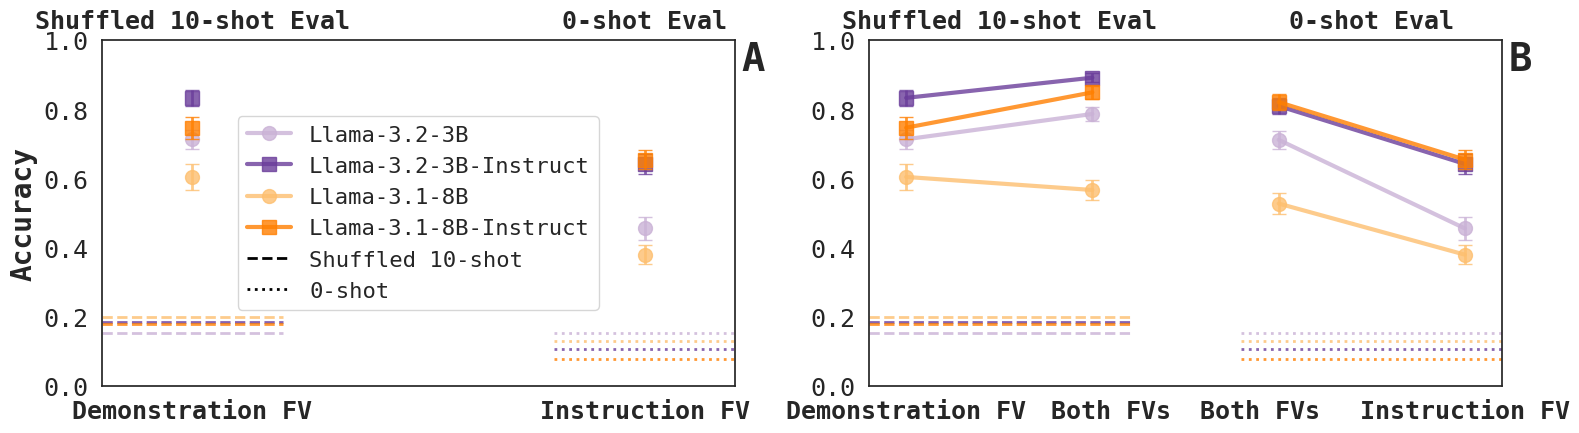

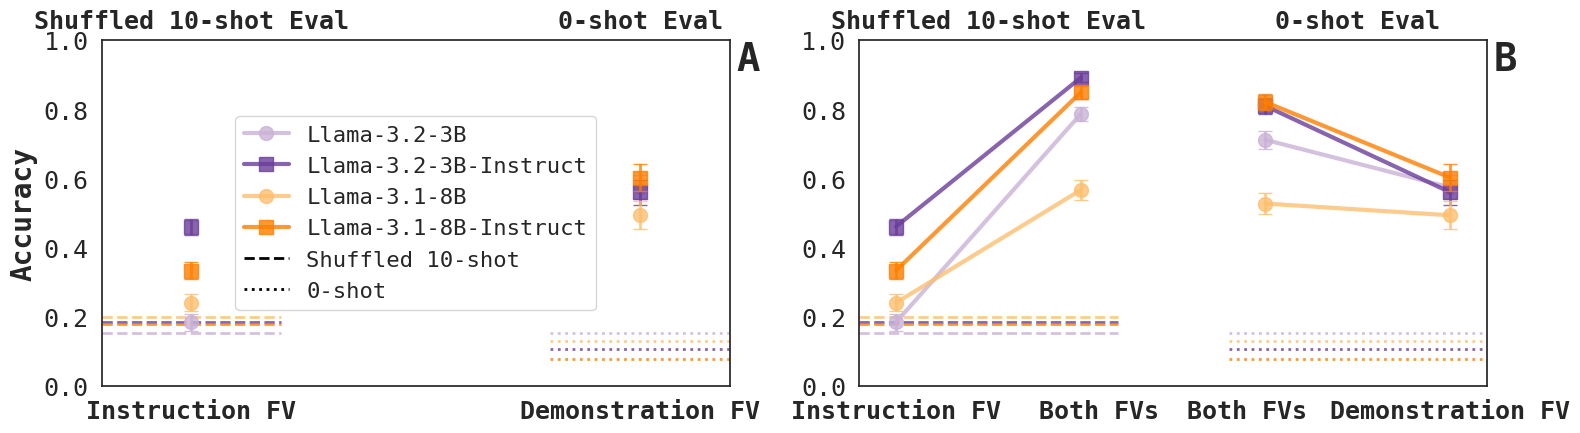

In [11]:
from palettable.colorbrewer.qualitative import Paired_12 as cmap

matched_eval_cols_and_baselines = [
    [
        (
            "ICL FV shuffled 10-shot (20 heads)",
            FEW_SHOT_SHUFFLED_BASELINE_METRICS,
        ),
        ("Prompt FV 0-shot (20 heads)", ZERO_SHOT_BASELINE_METRICS),
    ],
    [
        (
            ["ICL FV shuffled 10-shot (20 heads)", "Joint FV shuffled 10-shot (20 heads)"],
            FEW_SHOT_SHUFFLED_BASELINE_METRICS,
        ),
        (
            [
                "Joint FV 0-shot (20 heads)",
                "Prompt FV 0-shot (20 heads)",
            ],
            ZERO_SHOT_BASELINE_METRICS,
        ),
    ],
]

unmatched_eval_cols_and_baselines = [
    [
        (
            "Prompt FV shuffled 10-shot (20 heads)",
            FEW_SHOT_SHUFFLED_BASELINE_METRICS,
        ),
        ("ICL FV 0-shot (20 heads)", ZERO_SHOT_BASELINE_METRICS),
    ],
    [
        (
            [
                "Prompt FV shuffled 10-shot (20 heads)",
                "Joint FV shuffled 10-shot (20 heads)",
            ],
            FEW_SHOT_SHUFFLED_BASELINE_METRICS,
        ),
        (
            [
                "Joint FV 0-shot (20 heads)",
                "ICL FV 0-shot (20 heads)",
            ],
            ZERO_SHOT_BASELINE_METRICS,
        ),
    ],
]


for f, (figure_suffix, metric_and_baseline_names) in enumerate(
    (
        ("matched_evals", matched_eval_cols_and_baselines),
        ("unmatched_evals", unmatched_eval_cols_and_baselines),
    )
):
    fig, axes = plt.subplots(1, len(metric_and_baseline_names), figsize=(16, 4.5))

    for i, ax_metric_and_baseline_names in enumerate(metric_and_baseline_names):
        plot_connected_scatter(
            combined_model_dicts,
            MAIN_PLOT_MODELS,
            metric_and_baseline_names=ax_metric_and_baseline_names,
            metric_group_names=METRIC_GROUP_NAMES if i == 0 else METRIC_GROUP_NAMES[i - 1],
            metric_labels={
                #     "ICL FV shuffled 10-shot (20 heads)": "Demonstration\nFV",
                #     "Prompt FV shuffled 10-shot (20 heads)": "Instruction\nFV",
                #     "ICL FV 0-shot (20 heads)": "Demonstration\nFV",
                #     "Prompt FV 0-shot (20 heads)": "Instruction\nFV",
                #     "ICL activations FV 0-shot (20 heads)": "Inst heads\nDemo acts",
                #     "ICL top heads FV 0-shot (20 heads)": "Demo heads\nInst acts",
                #     "ICL activations FV shuffled 10-shot (20 heads)": "Inst heads\nDemo acts",
                #     "ICL top heads FV shuffled 10-shot (20 heads)": "Demo heads\nInst acts",
                "Joint FV 0-shot (20 heads)": "Both FVs",
                "Joint FV shuffled 10-shot (20 heads)": "Both FVs",
            },
            fontsize=20,
            fontfamily="monospace",
            font_inc=0,
            # width=10,
            # height=4,
            yticks=np.linspace(0, 1, 6),
            ylabel="Accuracy" if i == 0 else "",
            baseline_x_inside_increment=0.2,
            xtick_nudges=[0, 0.1, -0.1, 0] if i == 1 else 0,
            # baseline_annotation_nudges={
            #     "10-shot": -0.05,
            #     "Shuffled 10-shot": -0.06,
            # },
            legend_outside=False,
            legend_loc="center",
            legend_fontsize=16,
            show_legend=i == 0,
            add_legend_baseline_entries=True,
            ax=axes[i],
            annotate_panel=chr(ord("A") + i),
            should_show=False,
        )

    plt.tight_layout()
    save_plot(f"finding_1_2_main_and_joint_{figure_suffix}_{LAYER_PLOT_SUFFIX}.pdf")
    plt.show()


# Finding 4 in the reversed formulation, what if localizers but vertical


In [ ]:
matched_eval_cols_and_baselines = [
    [
        (
            [
                "ICL activations FV shuffled 10-shot (20 heads)",
                "ICL FV shuffled 10-shot (20 heads)",
                "ICL top heads FV shuffled 10-shot (20 heads)",
            ],
            FEW_SHOT_SHUFFLED_BASELINE_METRICS,
        ),
    ],
    [
        (
            [
                "ICL activations FV 0-shot (20 heads)",
                "Prompt FV 0-shot (20 heads)",
                "ICL top heads FV 0-shot (20 heads)",
            ],
            ZERO_SHOT_BASELINE_METRICS,
        ),
    ],
]

unmatched_eval_cols_and_baselines = [
    [
        (
            [
                "ICL activations FV 0-shot (20 heads)",
                "ICL FV 0-shot (20 heads)",
                "ICL top heads FV 0-shot (20 heads)",
            ],
            FEW_SHOT_SHUFFLED_BASELINE_METRICS,
        ),
    ],
    [
        (
            [
                "ICL activations FV shuffled 10-shot (20 heads)",
                "Prompt FV shuffled 10-shot (20 heads)",
                "ICL top heads FV shuffled 10-shot (20 heads)",
            ],
            ZERO_SHOT_BASELINE_METRICS,
        ),
    ],
]


for f, (figure_suffix, metric_and_baseline_names) in enumerate(
    (
        ("matched_evals", matched_eval_cols_and_baselines),
        ("unmatched_evals", unmatched_eval_cols_and_baselines),
    )
):
    fig, axes = plt.subplots(len(metric_and_baseline_names), 1, figsize=(6, 9))

    for i, ax_metric_and_baseline_names in enumerate(metric_and_baseline_names):
        plot_connected_scatter(
            combined_model_dicts,
            MAIN_PLOT_MODELS,
            metric_and_baseline_names=ax_metric_and_baseline_names,
            metric_group_names=METRIC_GROUP_NAMES if i == 0 else METRIC_GROUP_NAMES[i - 1],
            metric_labels={
                "ICL FV shuffled 10-shot (20 heads)": "Demonstration\nFV",
                "Prompt FV shuffled 10-shot (20 heads)": "Instruction\nFV",
                "ICL FV 0-shot (20 heads)": "Demonstration\nFV",
                "Prompt FV 0-shot (20 heads)": "Instruction\nFV",
                "ICL activations FV 0-shot (20 heads)": "Inst heads\nDemo acts",
                "ICL top heads FV 0-shot (20 heads)": "Demo heads\nInst acts",
                "ICL activations FV shuffled 10-shot (20 heads)": "Inst heads\nDemo acts",
                "ICL top heads FV shuffled 10-shot (20 heads)": "Demo heads\nInst acts",
            },
            fontsize=19,
            fontfamily="monospace",
            font_inc=0,
            # width=10,
            # height=4,
            legend_outside=False,
            legend_loc="upper right",
            legend_fontsize=12,
            yticks=np.linspace(0, 1, 6),
            # baseline_annotation_nudges={
            #     "10-shot": -0.05,
            #     "Shuffled 10-shot": -0.06,
            # },
            baseline_x_inside_increment=0.2,
            should_show=False,
            show_legend=i == 1,
            ylabel="Accuracy",
            ax=axes[i],
            annotate_panel=chr(ord("G") + i),
        )

    plt.tight_layout()
    save_plot(f"finding_4_localizers_vertical_{figure_suffix}_{LAYER_PLOT_SUFFIX}.pdf")
    plt.show()


# RQ 2.2-2.3 joint and localizers in one figure


In [ ]:
matched_eval_cols_and_baselines = [
    [
        (
            ["ICL FV shuffled 10-shot (20 heads)", "Joint FV shuffled 10-shot (20 heads)"],
            FEW_SHOT_SHUFFLED_BASELINE_METRICS,
        ),
        (
            [
                "Joint FV 0-shot (20 heads)",
                "Prompt FV 0-shot (20 heads)",
            ],
            ZERO_SHOT_BASELINE_METRICS,
        ),
    ],
    [
        (
            [
                "ICL activations FV shuffled 10-shot (20 heads)",
                "ICL FV shuffled 10-shot (20 heads)",
                "ICL top heads FV shuffled 10-shot (20 heads)",
            ],
            FEW_SHOT_SHUFFLED_BASELINE_METRICS,
        ),
    ],
    [
        (
            [
                "ICL activations FV 0-shot (20 heads)",
                "Prompt FV 0-shot (20 heads)",
                "ICL top heads FV 0-shot (20 heads)",
            ],
            ZERO_SHOT_BASELINE_METRICS,
        ),
    ],
]

unmatched_eval_cols_and_baselines = [
    [
        (
            [
                "Prompt FV shuffled 10-shot (20 heads)",
                "Joint FV shuffled 10-shot (20 heads)",
            ],
            FEW_SHOT_SHUFFLED_BASELINE_METRICS,
        ),
        (
            [
                "Joint FV 0-shot (20 heads)",
                "ICL FV 0-shot (20 heads)",
            ],
            ZERO_SHOT_BASELINE_METRICS,
        ),
    ],
    [
        (
            [
                "ICL activations FV 0-shot (20 heads)",
                "ICL FV 0-shot (20 heads)",
                "ICL top heads FV 0-shot (20 heads)",
            ],
            FEW_SHOT_SHUFFLED_BASELINE_METRICS,
        ),
    ],
    [
        (
            [
                "ICL activations FV shuffled 10-shot (20 heads)",
                "Prompt FV shuffled 10-shot (20 heads)",
                "ICL top heads FV shuffled 10-shot (20 heads)",
            ],
            ZERO_SHOT_BASELINE_METRICS,
        ),
    ],
]


for f, (figure_suffix, metric_and_baseline_names) in enumerate(
    (
        ("matched_evals", matched_eval_cols_and_baselines),
        ("unmatched_evals", unmatched_eval_cols_and_baselines),
    )
):
    fig, axes = plt.subplots(1, len(metric_and_baseline_names), figsize=(20, 6))

    for i, ax_metric_and_baseline_names in enumerate(metric_and_baseline_names):
        plot_connected_scatter(
            combined_model_dicts,
            MAIN_PLOT_MODELS,
            metric_and_baseline_names=ax_metric_and_baseline_names,
            metric_group_names=METRIC_GROUP_NAMES if i == 0 else METRIC_GROUP_NAMES[i - 1],
            metric_labels={
                "ICL FV shuffled 10-shot (20 heads)": "Demonstration\nFV",
                "Prompt FV shuffled 10-shot (20 heads)": "Instruction\nFV",
                "ICL FV 0-shot (20 heads)": "Demonstration\nFV",
                "Prompt FV 0-shot (20 heads)": "Instruction\nFV",
                "ICL activations FV 0-shot (20 heads)": "Inst heads\nDemo acts",
                "ICL top heads FV 0-shot (20 heads)": "Demo heads\nInst acts",
                "ICL activations FV shuffled 10-shot (20 heads)": "Inst heads\nDemo acts",
                "ICL top heads FV shuffled 10-shot (20 heads)": "Demo heads\nInst acts",
            },
            fontsize=20,
            fontfamily="monospace",
            font_inc=0,
            # width=10,
            # height=4,
            legend_outside=False,
            legend_loc="upper right",
            legend_fontsize=16,
            yticks=np.linspace(0, 1, 6),
            # baseline_annotation_nudges={
            #     "10-shot": -0.05,
            #     "Shuffled 10-shot": -0.06,
            # },
            baseline_x_inside_increment=0.2,
            should_show=False,
            show_legend=i == 2,
            ylabel="Accuracy" if i == 0 else "",
            ax=axes[i],
            annotate_panel=chr(ord("A") + i),
        )

    plt.tight_layout()
    save_plot(f"rq2_2_3_joint_and_localizers_{figure_suffix}_{LAYER_PLOT_SUFFIX}.pdf")
    plt.show()


# RQ 2.2A Joint intervention


In [ ]:
matched_eval_cols_and_baselines = [
    (
        ["ICL FV shuffled 10-shot (20 heads)", "Joint FV shuffled 10-shot (20 heads)"],
        FEW_SHOT_SHUFFLED_BASELINE_METRICS,
    ),
    (
        [
            "Joint FV 0-shot (20 heads)",
            "Prompt FV 0-shot (20 heads)",
        ],
        ZERO_SHOT_BASELINE_METRICS,
    ),
]

unmatched_eval_cols_and_baselines = [
    (
        [
            "Prompt FV shuffled 10-shot (20 heads)",
            "Joint FV shuffled 10-shot (20 heads)",
        ],
        FEW_SHOT_SHUFFLED_BASELINE_METRICS,
    ),
    (
        [
            "Joint FV 0-shot (20 heads)",
            "ICL FV 0-shot (20 heads)",
        ],
        ZERO_SHOT_BASELINE_METRICS,
    ),
]


for figure_suffix, metric_and_baseline_names in (
    ("matched_evals", matched_eval_cols_and_baselines),
    ("unmatched_evals", unmatched_eval_cols_and_baselines),
):
    plot_connected_scatter(
        combined_model_dicts,
        MAIN_PLOT_MODELS,
        metric_and_baseline_names=metric_and_baseline_names,
        fontsize=16,
        fontfamily="monospace",
        font_inc=0,
        width=8,
        height=4,
        legend_outside=False,
        legend_loc=(0.2, 0.4) if USE_ONE_THIRD_LAYER else "lower center",
        legend_fontsize=12,
        yticks=np.linspace(0, 1, 6),
        baseline_annotation_nudges={
            "10-shot": -0.05,
            "Shuffled 10-shot": -0.06,
        },
        baseline_x_inside_increment=0.2,
        should_show=False,
        # show_legend=i == 0,
        # ylabel="Accuracy" if i == 0 else "",
        annotate_panel="A",
    )

    plt.tight_layout()
    save_plot(f"rq2_2_joint_intervention_{figure_suffix}_{LAYER_PLOT_SUFFIX}.pdf")
    plt.show()


# RQ2.3 localizer experiment


In [ ]:
matched_eval_cols_and_baselines = [
    [
        (
            [
                "ICL activations FV shuffled 10-shot (20 heads)",
                "ICL FV shuffled 10-shot (20 heads)",
                "ICL top heads FV shuffled 10-shot (20 heads)",
            ],
            FEW_SHOT_SHUFFLED_BASELINE_METRICS,
        ),
    ],
    [
        (
            [
                "ICL activations FV 0-shot (20 heads)",
                "Prompt FV 0-shot (20 heads)",
                "ICL top heads FV 0-shot (20 heads)",
            ],
            ZERO_SHOT_BASELINE_METRICS,
        ),
    ],
]

unmatched_eval_cols_and_baselines = [
    [
        (
            [
                "ICL activations FV 0-shot (20 heads)",
                "ICL FV 0-shot (20 heads)",
                "ICL top heads FV 0-shot (20 heads)",
            ],
            FEW_SHOT_SHUFFLED_BASELINE_METRICS,
        ),
    ],
    [
        (
            [
                "ICL activations FV shuffled 10-shot (20 heads)",
                "Prompt FV shuffled 10-shot (20 heads)",
                "ICL top heads FV shuffled 10-shot (20 heads)",
            ],
            ZERO_SHOT_BASELINE_METRICS,
        ),
    ],
]


for f, (figure_suffix, metric_and_baseline_names) in enumerate(
    (
        ("matched_evals", matched_eval_cols_and_baselines),
        ("unmatched_evals", unmatched_eval_cols_and_baselines),
    )
):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    for i, ax_metric_and_baseline_names in enumerate(metric_and_baseline_names):
        plot_connected_scatter(
            combined_model_dicts,
            MAIN_PLOT_MODELS,
            metric_and_baseline_names=ax_metric_and_baseline_names,
            metric_group_names=METRIC_GROUP_NAMES[i],
            fontsize=18,
            fontfamily="monospace",
            font_inc=0,
            width=10,
            height=4,
            legend_outside=False,
            legend_loc="upper right",
            legend_fontsize=16,
            yticks=np.linspace(0, 1, 6),
            # baseline_annotation_nudges={
            #     "10-shot": -0.05,
            #     "Shuffled 10-shot": -0.06,
            # },
            baseline_x_inside_increment=0.2,
            should_show=False,
            show_legend=i == 1,
            ylabel="Accuracy" if i == 0 else "",
            ax=axes[i],
            annotate_panel=chr(ord("B") + i),
        )

    plt.tight_layout()
    save_plot(f"rq2_3_localizers_{figure_suffix}_{LAYER_PLOT_SUFFIX}.pdf")
    plt.show()


Trying a diff figure


In [ ]:
diff_metric_and_baseline_names = [
    [
        (
            [
                "ICL FV - ICL activations shuffled 10-shot (20 heads)",
                "ICL FV - ICL top heads shuffled 10-shot (20 heads)",
            ],
            FEW_SHOT_SHUFFLED_BASELINE_METRICS,
        ),
    ],
    [
        (
            [
                "Prompt FV - ICL activations 0-shot (20 heads)",
                "Prompt FV - ICL top heads 0-shot (20 heads)",
            ],
            ZERO_SHOT_BASELINE_METRICS,
        ),
    ],
]

figure_suffix = "matched_evals"
YMAX = -1

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, ax_metric_and_baseline_names in enumerate(diff_metric_and_baseline_names):
    plot_connected_scatter(
        combined_model_dicts,
        MAIN_PLOT_MODELS,
        metric_and_baseline_names=ax_metric_and_baseline_names,
        metric_group_names=METRIC_GROUP_NAMES[i],
        data_scaler=lambda x: x * -1,
        fontsize=18,
        fontfamily="monospace",
        font_inc=0,
        width=10,
        height=10,
        legend_outside=False,
        legend_loc="upper right",
        legend_fontsize=16,
        ylim=(-1, 0),
        # ylim=(0, YMAX),
        yticks=np.linspace(0, YMAX, 9),
        # show_error_bars=False,
        # baseline_annotation_nudges={
        #     "10-shot": -0.05,
        #     "Shuffled 10-shot": -0.06,
        # },
        baseline_x_inside_increment=0.2,
        should_show=False,
        # show_legend=i == 0,
        show_legend=False,
        ylabel="Accuracy Loss" if i == 0 else "",
        ax=axes[i],
        annotate_panel=chr(ord("A") + i),
    )

plt.tight_layout()
# save_plot(f"rq2_3_localizer_diffs_{figure_suffix}_{LAYER_PLOT_SUFFIX}.pdf")
plt.show()


This figure, but as a table


In [ ]:
metric_groups = [
    [
        "ICL FV shuffled 10-shot (20 heads)",
        "ICL activations FV shuffled 10-shot (20 heads)",
        "ICL top heads FV shuffled 10-shot (20 heads)",
    ],
    [
        "Prompt FV 0-shot (20 heads)",
        "ICL activations FV 0-shot (20 heads)",
        "ICL top heads FV 0-shot (20 heads)",
    ],
]


table_rows = []
diffs_by_metric = defaultdict(list)

for model in MAIN_PLOT_MODELS:
    model_metrics = combined_model_dicts[model]
    row = dict(model=model)
    for metric_group in metric_groups:
        ref_metric = metric_group[0]
        ref_value = model_metrics[ref_metric][0]
        row[ref_metric] = f"{ref_value:.4f}"

        for rel_metric in metric_group[1:]:
            rel_value = model_metrics[rel_metric][0]
            diff = rel_value - ref_value
            diffs_by_metric[rel_metric].append(diff)
            row[rel_metric] = f"{rel_value:.4f} ({diff:.4f})"

    table_rows.append(row)

diff_row = dict(
    model="Mean difference",
    **{
        metric: None if metric not in diffs_by_metric else f"{np.mean(diffs_by_metric[metric]):.4f}"
        for metric in itertools.chain.from_iterable(metric_groups)
    },
)
table_rows.append(diff_row)

# table_rows = [
#     {METRIC_PLOT_LABELS.get(k, k).replace("\n", " "): v for k, v in row.items()}
#     for row in table_rows
# ]

transpose = True
if transpose:
    table_rows = pd.DataFrame(table_rows).set_index("model").T

table_format = "latex_booktabs"
table = tabulate.tabulate(table_rows, headers="keys", tablefmt=table_format)

if table_format == "github":
    display(Markdown(table))
else:
    print(table)

# Older Plots


In [ ]:
summary_cols_nice_names = [
    "10-shot",
    # 'Top-1 prompt',
    "Top-5 prompts (mean)",
    "0-shot",
    "ICL FV 0-shot (10 heads)",
    "Prompt FV 0-shot (10 heads)",
    "Joint FV 0-shot (10 heads)",
    "ICL FV 0-shot (20 heads)",
    "Prompt FV 0-shot (20 heads)",
    "Joint FV 0-shot (20 heads)",
]

metric_labels = [
    "ICL baseline (10-shot)",
    "Prompt baseline (Top-5)",
    "0-shot",
    "0-shot + ICL FV (10 heads)",
    "0-shot + Prompt FV (10)",
    "0-shot + Joint FV (10)",
    "0-shot + ICL FV (20)",
    "0-shot + Prompt FV (20)",
    "0-shot + Joint FV (20)",
]


ordered_color_indices = [10, 11, 6, 2, 8, 7, 3, 9]

colors = [cmap.mpl_colors[i] for i in ordered_color_indices]
colors.insert(0, (0.8, 0.8, 0.8))


for i in range(0, len(RELEVANT_MODELS), 2):
    plot_metric_grouped_bar_chart(
        zero_shot_model_dicts,
        RELEVANT_MODELS[i : i + 2],
        summary_cols_nice_names,
        colors=colors,
        metric_labels=metric_labels,
        title=RELEVANT_MODELS[i] + " family | 0-shot",
    )

In [ ]:
shuffled_10_shot_cols_nice_names = [
    "10-shot",
    # 'Top-1 prompt',
    "Top-5 prompts (mean)",
    "Shuffled 10-shot",
    "ICL FV shuffled 10-shot (10 heads)",
    "Prompt FV shuffled 10-shot (10 heads)",
    "Joint FV shuffled 10-shot (10 heads)",
    "ICL FV shuffled 10-shot (20 heads)",
    "Prompt FV shuffled 10-shot (20 heads)",
    "Joint FV shuffled 10-shot (20 heads)",
]


shuffled_10_shot_metric_labels = [
    "ICL baseline (10-shot)",
    "Prompt baseline (Top-5)",
    "Shuffled 10-shot",
    "S 10-shot + ICL FV (10 heads)",
    "S 10-shot + Prompt FV (10)",
    "S 10-shot + Joint FV (10)",
    "S 10-shot + ICL FV (20)",
    "S 10-shot + Prompt FV (20)",
    "S 10-shot + Joint FV (20)",
]


for i in range(0, len(RELEVANT_MODELS), 2):
    plot_metric_grouped_bar_chart(
        shuffled_ten_shot_model_dicts,
        RELEVANT_MODELS[i : i + 2],
        shuffled_10_shot_cols_nice_names,
        colors=colors,
        metric_labels=shuffled_10_shot_metric_labels,
        title=RELEVANT_MODELS[i] + " family | shuffled 10-shot",
    )

Joint intervention works very well in most cases (some oddity with Llama-3.2-3B), including outperforming botht individual FVs and even the full 10-shot or prompt baseline.

# RQ4: Can we ues the localizer framing to show separation?


In [ ]:
result_with_same_layer_localizers_df = result_with_same_layer_acc_df

result_with_same_layer_localizers_df = add_same_layer_results(
    result_with_same_layer_localizers_df,
    special_type="icl_top_heads",
    include_icl=False,
    use_both_zs_and_fs_for_top_layer=True,
)


result_with_same_layer_localizers_df = add_same_layer_results(
    result_with_same_layer_localizers_df,
    special_type="icl_mean_activations",
    include_icl=False,
    use_both_zs_and_fs_for_top_layer=True,
)

row_filter = result_with_same_layer_localizers_df.apply(
    lambda row: row.dataset not in MISSING_DATASETS_BY_MODEL[row.model], axis=1
)

matched_datasets_result_with_same_layer_localizers_df = result_with_same_layer_localizers_df[row_filter].copy(deep=True)

In [ ]:
summary_columns = [
    "10_shot_acc",
    "top_1_prompt_acc",
    "top_n_prompt_acc",
    "0_shot_acc",
    "zs_universal_both_all_10_heads_same_layer_acc",
    "zs_universal_icl_all_10_heads_same_layer_acc",
    "zs_universal_both_joint_intervention_all_10_heads_same_layer_acc",
    "zs_universal_both_icl_mean_activations_all_10_heads_same_layer_acc",
    "zs_universal_both_icl_top_heads_all_10_heads_same_layer_acc",
    "zs_universal_both_all_20_heads_same_layer_acc",
    "zs_universal_icl_all_20_heads_same_layer_acc",
    "zs_universal_both_joint_intervention_all_20_heads_same_layer_acc",
    "zs_universal_both_icl_mean_activations_all_20_heads_same_layer_acc",
    "zs_universal_both_icl_top_heads_all_20_heads_same_layer_acc",
]

summary_columns_shuffled_10_shot = [
    "10_shot_acc",
    "top_1_prompt_acc",
    "top_n_prompt_acc",
    "shuffled_10_shot_acc",
    "fs_shuffled_universal_both_all_10_heads_same_layer_acc",
    "fs_shuffled_universal_icl_all_10_heads_same_layer_acc",
    "fs_shuffled_universal_both_joint_intervention_all_10_heads_same_layer_acc",
    "fs_shuffled_universal_both_icl_mean_activations_all_10_heads_same_layer_acc",
    "fs_shuffled_universal_both_icl_top_heads_all_10_heads_same_layer_acc",
    "fs_shuffled_universal_both_all_20_heads_same_layer_acc",
    "fs_shuffled_universal_icl_all_20_heads_same_layer_acc",
    "fs_shuffled_universal_both_joint_intervention_all_20_heads_same_layer_acc",
    "fs_shuffled_universal_both_icl_mean_activations_all_20_heads_same_layer_acc",
    "fs_shuffled_universal_both_icl_top_heads_all_20_heads_same_layer_acc",
]

display(Markdown("## Summary (aggregated by model) - 0-shot"))
localizers_zero_shot_metric_dicts = print_summary(
    matched_datasets_result_with_same_layer_localizers_df, summary_columns, [3, 9]
)
display(Markdown("## Summary (aggregated by model) - Shuffled 10-shot"))
localizers_shuffled_ten_shot_metric_dicts = print_summary(
    matched_datasets_result_with_same_layer_localizers_df, summary_columns_shuffled_10_shot, [3, 9]
)


localizers_zero_shot_model_dicts = defaultdict(dict)
for metric_dict in localizers_zero_shot_metric_dicts:
    metric_dict = {**metric_dict}
    metric = metric_dict.pop("metric")
    for model, value in metric_dict.items():
        localizers_zero_shot_model_dicts[model][metric] = value


localizers_shuffled_ten_shot_model_dicts = defaultdict(dict)
for metric_dict in localizers_shuffled_ten_shot_metric_dicts:
    metric_dict = {**metric_dict}
    metric = metric_dict.pop("metric")
    for model, value in metric_dict.items():
        localizers_shuffled_ten_shot_model_dicts[model][metric] = value

In [ ]:
summary_cols_nice_names = [
    "10-shot",
    "Top-5 prompts (mean)",
    "0-shot",
    "ICL FV 0-shot (10 heads)",
    "Prompt FV 0-shot (10 heads)",
    "Joint FV 0-shot (10 heads)",
    "ICL activations FV 0-shot (10 heads)",
    "ICL top heads FV 0-shot (10 heads)",
]

metric_labels = [
    "ICL baseline (10-shot)",
    "Prompt baseline (Top-5)",
    "0-shot",
    "0-shot + ICL FV (10 heads)",
    "0-shot + Prompt FV (10)",
    "0-shot + Joint FV (10)",
    "0-shot + ICL activations FV (10)",
    "0-shot + ICL heads FV (10)",
]

summary_cols_nice_names_20_heads = [c.replace("(10 heads)", "(20 heads)") for c in summary_cols_nice_names]

metric_labels_20_heads = [c.replace("(10 heads)", "(20 heads)").replace("(10)", "(20)") for c in metric_labels]


ordered_color_indices = [
    10,
    11,
    6,
    2,
    8,
    4,
    0,
]

colors = [cmap.mpl_colors[i] for i in ordered_color_indices]
colors.insert(0, (0.8, 0.8, 0.8))

ordered_color_indices_20_heads = [
    10,
    11,
    7,
    3,
    9,
    5,
    1,
]

colors_20_heads = [cmap.mpl_colors[i] for i in ordered_color_indices_20_heads]
colors_20_heads.insert(0, (0.8, 0.8, 0.8))

for i in range(0, len(RELEVANT_MODELS), 2):
    plot_metric_grouped_bar_chart(
        localizers_zero_shot_model_dicts,
        RELEVANT_MODELS[i : i + 2],
        summary_cols_nice_names,
        colors=colors,
        metric_labels=metric_labels,
        title=RELEVANT_MODELS[i] + " family | 0-shot | 10 heads",
    )

    plot_metric_grouped_bar_chart(
        localizers_zero_shot_model_dicts,
        RELEVANT_MODELS[i : i + 2],
        summary_cols_nice_names_20_heads,
        colors=colors_20_heads,
        metric_labels=metric_labels_20_heads,
        title=RELEVANT_MODELS[i] + " family | 0-shot | 20 heads",
    )


In [ ]:
shuffled_10_shot_cols_nice_names = [
    "10-shot",
    "Top-5 prompts (mean)",
    "Shuffled 10-shot",
    "ICL FV shuffled 10-shot (10 heads)",
    "Prompt FV shuffled 10-shot (10 heads)",
    "Joint FV shuffled 10-shot (10 heads)",
    "ICL activations FV shuffled 10-shot (10 heads)",
    "ICL top heads FV shuffled 10-shot (10 heads)",
]


shuffled_10_shot_metric_labels = [
    "ICL baseline (10-shot)",
    "Prompt baseline (Top-5)",
    "Shuffled 10-shot",
    "S 10-shot + ICL FV (10 heads)",
    "S 10-shot + Prompt FV (10)",
    "S 10-shot + Joint FV (10)",
    "S 10-shot + ICL activations FV (10)",
    "S 10-shot + ICL heads FV (10)",
]


shuffled_10_shot_summary_cols_nice_names_20_heads = [
    c.replace("(10 heads)", "(20 heads)") for c in shuffled_10_shot_cols_nice_names
]

shuffled_10_shot_metric_labels_20_heads = [
    c.replace("(10 heads)", "(20 heads)").replace("(10)", "(20)") for c in shuffled_10_shot_metric_labels
]


for i in range(0, len(RELEVANT_MODELS), 2):
    plot_metric_grouped_bar_chart(
        localizers_shuffled_ten_shot_model_dicts,
        RELEVANT_MODELS[i : i + 2],
        shuffled_10_shot_cols_nice_names,
        colors=colors,
        metric_labels=shuffled_10_shot_metric_labels,
        title=RELEVANT_MODELS[i] + " family | S 10-shot | 10 heads",
    )

    plot_metric_grouped_bar_chart(
        localizers_shuffled_ten_shot_model_dicts,
        RELEVANT_MODELS[i : i + 2],
        shuffled_10_shot_summary_cols_nice_names_20_heads,
        colors=colors_20_heads,
        metric_labels=shuffled_10_shot_metric_labels_20_heads,
        title=RELEVANT_MODELS[i] + " family | S 10-shot | 20 heads",
    )


In [ ]:
datasets = set(
    """antonym,capitalize,country-capital,country-currency,english-french,english-spanish,next_item,present-past,singular-plural,synonym,product-company,conll2003_location,conll2003_organization,conll2003_person,animal_v_object_3,animal_v_object_5,verb_v_adjective_3,verb_v_adjective_5,word_length,next_capital_letter,prev_item,national_parks,capitalize_first_letter,capitalize_second_letter,capitalize_last_letter,lowercase_first_letter,lowercase_last_letter,color_v_animal_3,color_v_animal_5,fruit_v_animal_3,fruit_v_animal_5,concept_v_object_3,concept_v_object_5,object_v_concept_3,object_v_concept_5,choose_first_of_3,choose_first_of_5,choose_middle_of_3,choose_middle_of_5,choose_last_of_3,choose_last_of_5,alphabetically_first_3,alphabetically_first_5,alphabetically_last_3,alphabetically_last_5,adjective_v_verb_3,adjective_v_verb_5,english-german,landmark-country,park-country""".split(
        ","
    )
)


In [ ]:
from collections import Counter

{k: v for (k, v) in Counter(found_datasets).items() if v > 1}